## Preprocessing

In [1]:
import pandas as pd
import re
import spacy

import torch
from torch_geometric.data import HeteroData

import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

In [2]:
filename = 'data/arxiv-metadata-oai-snapshot-10000.csv'
df = pd.read_csv(filename)

In [3]:
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,NaN,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[['Balázs', 'C.', ''], ['Berger', 'E. L.', '']..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,NaN,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[['Streinu', 'Ileana', ''], ['Theran', 'Louis'..."
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,NaN,physics.gen-ph,NaN,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[['Pan', 'Hongjun', '']]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,NaN,NaN,NaN,math.CO,NaN,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[['Callan', 'David', '']]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,NaN,"Illinois J. Math. 52 (2008) no.2, 681-689",NaN,NaN,math.CA math.FA,NaN,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[['Abu-Shammala', 'Wael', ''], ['Torchinsky', ..."


In [4]:
# extract number of pages from string: e.g. "37 pages, 15 figures; published version"

def extract_pages(s):
    match = re.search(r"(\d+)\s*pages", s)
    if match:
        return int(match.group(1))
    else:
        return None

In [5]:
# format columns to right format and extract information
# Quelle warum genau die neuen Spalten?


df['authors_parsed'] = df['authors_parsed'].apply(lambda x: [" ".join(i).strip() for i in eval(x)]) # authors to name, first name and list
df['versions'] = df['versions'].apply(lambda x: eval(x)[0]["created"]) # first version / created
df['timestamp'] = pd.to_datetime(df['versions'], format="%a, %d %b %Y %H:%M:%S %Z") # 
df['timestamp'] = df['timestamp'].apply(lambda x: x.timestamp())
df["categories"] = df["categories"].apply(lambda x: x.split(" ")) # sdeperate categories by comma
df.drop(columns=["submitter", "versions", "update_date", "authors"], inplace=True)
df["pages"] = df.comments.apply(lambda x: extract_pages(str(x))) # extract page number
df.head()

,id,title,comments,journal-ref,doi,report-no,categories,license,abstract,authors_parsed,timestamp,pages
0,704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,[hep-ph],NaN,A fully differential calculation in perturba...,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",1.175542e+09,37.0
1,704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,NaN,"[math.CO, cs.CG]",http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[Streinu Ileana, Theran Louis]",1.175308e+09,NaN
2,704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,NaN,[physics.gen-ph],NaN,The evolution of Earth-Moon system is descri...,[Pan Hongjun],1.175460e+09,23.0
3,704.0004,A determinant of Stirling cycle numbers counts...,11 pages,NaN,NaN,NaN,[math.CO],NaN,We show that a determinant of Stirling cycle...,[Callan David],1.175311e+09,11.0
4,704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,NaN,"Illinois J. Math. 52 (2008) no.2, 681-689",NaN,NaN,"[math.CA, math.FA]",NaN,In this paper we show how to compute the $\L...,"[Abu-Shammala Wael, Torchinsky Alberto]",1.175537e+09,NaN


In [6]:
grouped_by_author = []

for idx, row in df.iterrows():
    title = row['title']
    authors = row['authors_parsed']
    
    for author in authors:
        grouped_by_author.append({'Author': author, 'Title': title})

df_grouped = pd.DataFrame(grouped_by_author)

result = df_grouped.groupby('Author')['Title'].apply(list).reset_index()



author_counts = df_grouped['Author'].value_counts()

print(author_counts)

Author
Chablat Damien  IRCCyN     32
Poor H. Vincent            26
Marwala Tshilidzi          25
Wenger Philippe  IRCCyN    23
Sasano Yusuke              18
                           ..
Goyal H. C.  a              1
Ganesh S.  a                1
Chanchalani K.  a           1
Bhattacharyya S.  a         1
Rayaprol Sudhindra          1
Name: count, Length: 25304, dtype: int64


In [7]:
filtered_df = df[df['authors_parsed'].apply(lambda authors: 'Poor H. Vincent' in authors)]

print(filtered_df)

            id                                              title  \
1924  704.1925  Blind Identification of Distributed Antenna Sy...   
2258  704.2259  The Wiretap Channel with Feedback: Encryption ...   
2374  704.2375  Power control algorithms for CDMA networks bas...   
2382  704.2383  Power control and receiver design for energy e...   
2650  704.2651  Opportunistic Communications in an Orthogonal ...   
2840  704.2841  A High-Throughput Cross-Layer Scheme for Distr...   
3093  704.3094  Detection of two-sided alternatives in a Brown...   
3291  704.3292  Coalition Games with Cooperative Transmission:...   
3390  704.3391  Lifetime Improvement in Wireless Sensor Networ...   
3395  704.3396  Lifetime Improvement of Wireless Sensor Networ...   
3398  704.3399  Cooperative Transmission Protocols with High S...   
3404  704.3405  Estimation Diversity and Energy Efficiency in ...   
3407  704.3408  The Trade-off between Processing Gains of an I...   
3587  704.3588  On Energy Efficien

In [8]:
# def tokenize_and_normalize(text):
#     nlp = spacy.load("en_core_web_sm")
#     doc = nlp(text)
#     return [token.text.lower() for token in doc if not token.is_punct and not token.is_space]

# Lemmatisierung/Reduzierung der Wörter auf Basisform

def lemm(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_punct and not token.is_space]

In [9]:
df_short = df[:3]
df_short

,id,title,comments,journal-ref,doi,report-no,categories,license,abstract,authors_parsed,timestamp,pages
0,704.0001,Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,[hep-ph],NaN,A fully differential calculation in perturba...,"[Balázs C., Berger E. L., Nadolsky P. M., Yuan...",1.175542e+09,37.0
1,704.0002,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,NaN,NaN,NaN,"[math.CO, cs.CG]",http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[Streinu Ileana, Theran Louis]",1.175308e+09,NaN
2,704.0003,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",NaN,NaN,NaN,[physics.gen-ph],NaN,The evolution of Earth-Moon system is descri...,[Pan Hongjun],1.175460e+09,23.0


In [10]:
# create lists that contain lemmatized words from abstracts, titles, and lists of authors and categories for each entry in the DataFrame


# create list of variables with more than one value
# tokenized_words_list = []
# lemm_list = []
all_words, all_authors, all_categories, all_title_words = [], [], [], []
# authors = []
# categories = []
# lemm_title = []

for index, row in df_short.iterrows():
    text = row['abstract']
    title = row['title']
    author = row['authors_parsed']
    category = row['categories'] 
    # tokenized_words = tokenize_and_normalize(text)
    lemm_words = lemm(text)
    lemm_title_words = lemm(title)
    # tokenized_words_list.append(tokenized_words)
    all_words.append(lemm_words)
    all_authors.append(author)
    all_categories.append(category)
    all_title_words.append(lemm_title_words)


# print(tokenized_words_list)
print(all_words)
print(all_authors)
print(all_categories)
print(all_title_words)


[['a', 'fully', 'differential', 'calculation', 'in', 'perturbative', 'quantum', 'chromodynamic', 'be', 'present', 'for', 'the', 'production', 'of', 'massive', 'photon', 'pair', 'at', 'hadron', 'collider', 'all', 'next', 'to', 'lead', 'order', 'perturbative', 'contribution', 'from', 'quark', 'antiquark', 'gluon-(anti)quark', 'and', 'gluon', 'gluon', 'subprocesse', 'be', 'include', 'as', 'well', 'as', 'all', 'order', 'resummation', 'of', 'initial', 'state', 'gluon', 'radiation', 'valid', 'at', 'next', 'to', 'next', 'to', 'lead', 'logarithmic', 'accuracy', 'the', 'region', 'of', 'phase', 'space', 'be', 'specify', 'in', 'which', 'the', 'calculation', 'be', 'most', 'reliable', 'good', 'agreement', 'be', 'demonstrate', 'with', 'datum', 'from', 'the', 'Fermilab', 'Tevatron', 'and', 'prediction', 'be', 'make', 'for', 'more', 'detailed', 'test', 'with', 'CDF', 'and', 'do', 'datum', 'prediction', 'be', 'show', 'for', 'distribution', 'of', 'diphoton', 'pair', 'produce', 'at', 'the', 'energy', 'of

In [11]:
# print(tokenized_words_list[0])

In [12]:
# create lists with every value
# check every list of list and extract values

# words = [word for sublist in all_words for word in sublist]
words_values = [word for sublist in all_words for word in sublist]

print(words_values)

authors_values = [author for sublist in all_authors for author in sublist]

categories_values = [category for sublist in all_categories for category in sublist]

title_values = [title for sublist in all_title_words for title in sublist]


['a', 'fully', 'differential', 'calculation', 'in', 'perturbative', 'quantum', 'chromodynamic', 'be', 'present', 'for', 'the', 'production', 'of', 'massive', 'photon', 'pair', 'at', 'hadron', 'collider', 'all', 'next', 'to', 'lead', 'order', 'perturbative', 'contribution', 'from', 'quark', 'antiquark', 'gluon-(anti)quark', 'and', 'gluon', 'gluon', 'subprocesse', 'be', 'include', 'as', 'well', 'as', 'all', 'order', 'resummation', 'of', 'initial', 'state', 'gluon', 'radiation', 'valid', 'at', 'next', 'to', 'next', 'to', 'lead', 'logarithmic', 'accuracy', 'the', 'region', 'of', 'phase', 'space', 'be', 'specify', 'in', 'which', 'the', 'calculation', 'be', 'most', 'reliable', 'good', 'agreement', 'be', 'demonstrate', 'with', 'datum', 'from', 'the', 'Fermilab', 'Tevatron', 'and', 'prediction', 'be', 'make', 'for', 'more', 'detailed', 'test', 'with', 'CDF', 'and', 'do', 'datum', 'prediction', 'be', 'show', 'for', 'distribution', 'of', 'diphoton', 'pair', 'produce', 'at', 'the', 'energy', 'of'

In [13]:
# list with all words without duplicates
# warum keine Duplikate mehr???


words_list = []
for i in range(len(words_values)):
    if words_values[i] not in words_list:
        words_list.append(words_values[i])

authors_list = []
for i in range(len(authors_values)):
    if words_values[i] not in authors_list:
        authors_list.append(words_values[i])

categories_list = []
for i in range(len(categories_values)):
    if words_values[i] not in categories_list:
        categories_list.append(words_values[i])

title_words_list = []
for i in range(len(title_values)):
    if title_values[i] not in title_words_list:
        title_words_list.append(title_values[i])

In [14]:
print(words_list)
print(title_words_list)

['a', 'fully', 'differential', 'calculation', 'in', 'perturbative', 'quantum', 'chromodynamic', 'be', 'present', 'for', 'the', 'production', 'of', 'massive', 'photon', 'pair', 'at', 'hadron', 'collider', 'all', 'next', 'to', 'lead', 'order', 'contribution', 'from', 'quark', 'antiquark', 'gluon-(anti)quark', 'and', 'gluon', 'subprocesse', 'include', 'as', 'well', 'resummation', 'initial', 'state', 'radiation', 'valid', 'logarithmic', 'accuracy', 'region', 'phase', 'space', 'specify', 'which', 'most', 'reliable', 'good', 'agreement', 'demonstrate', 'with', 'datum', 'Fermilab', 'Tevatron', 'prediction', 'make', 'more', 'detailed', 'test', 'CDF', 'do', 'show', 'distribution', 'diphoton', 'produce', 'energy', 'Large', 'Hadron', 'Collider', 'LHC', 'decay', 'Higgs', 'boson', 'contrast', 'those', 'QCD', 'process', 'that', 'enhance', 'sensitivity', 'signal', 'can', 'obtain', 'judicious', 'selection', 'event', 'we', 'describe', 'new', 'algorithm', '$', 'k,\\ell)$-pebble', 'game', 'color', 'use',

In [15]:
for i in range(2):
    a = len(all_words[i])
    print(a)
# mit der Anzahl von Wörtern im Abstract könnte man zuordnen, welche Wörter zu welcher Arbeit gehören
# z.B. Wörter 0 bis 149 gehören zu paper1
# was machen mit gleichen Wörtern in mehreren Arbeiten

150
120


In [16]:
# text_list = [' '.join(words) for words in all_words]

# print(text_list)

# title_words_list = [' '.join(words) for words in all_title_words]

# print(title_words_list)

# brauchen wir eigentlich nicht

In [17]:
# list with titles
# title_list=[]
# for i in range(len(df_short)):
#     title_list.append(df_short.title[i])
# print(title_list)

In [18]:
# create lists of attributes 

licenses_list = []
def licenses_in_list(df):
    for i in range(len(df)):
        licenses_list.append(df.license[i])
    print(licenses_list)

doi_list = []
def doi_in_list(df):
    for i in range(len(df)):
        doi_list.append(df.doi[i])
    print(doi_list)

title_list = []
def titles_in_list(df):
    for i in range(len(df)):
        title_list.append(df.title[i])
    print(title_list)

comment_list = []
def comments_in_list(df):
    for i in range(len(df)):
        comment_list.append(df.comments[i])
    print(comment_list)


# author_list = []
# def authors_in_list(df):
#     for i in range(len(df)):
#         author_list.append(df.authors_parsed[i])
#     print(author_list)


# categories_list = []
# def categories_in_list(df):
#     for i in range(len(df)):
#         categories_list.append(df['categories'][i])
#     print(categories_list)


journal_list = []
def journals_in_list(df):
    for i in range(len(df)):
        journal_list.append(df['journal-ref'][i])
    print(journal_list)

words_in_title_list = []
def words_in_title(df):
    for i in range(len(df)):
        words_in_title_list.append(df.title[i].split())
    print(words_in_title_list)

In [19]:
licenses_in_list(df_short)
doi_in_list(df_short)
titles_in_list(df_short)
comments_in_list(df_short)
# authors_in_list(df_short)
# categories_in_list(df_short)
journals_in_list(df_short)

[nan, 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/', nan]
['10.1103/PhysRevD.76.013009', nan, nan]
['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Sparsity-certifying Graph Decompositions', 'The evolution of the Earth-Moon system based on the dark matter field\r\n  fluid model']
['37 pages, 15 figures; published version', 'To appear in Graphs and Combinatorics', '23 pages, 3 figures']
['Phys.Rev.D76:013009,2007', nan, nan]


In [20]:
licenses_list

[nan, 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/', nan]

In [21]:
data = HeteroData()
data['paper'].num_nodes = len(df_short)
data['paper'].license = licenses_list
data['paper'].doi = doi_list
data['paper'].title = title_list
data['paper'].comment = comment_list

data['author'].num_nodes = len(authors_list)
data['author'].name = authors_list

data['category'].num_nodes = len(categories_list)
data['category'].name = categories_list

data['journal'].num_nodes = len(df_short)
data['journal'].name = journal_list

data['word'].num_nodes = len(words_list)
data['word'].name = words_list

data

HeteroData(
  paper={
    num_nodes=3,
    license=[3],
    doi=[3],
    title=[3],
    comment=[3],
  },
  author={
    num_nodes=7,
    name=[7],
  },
  category={
    num_nodes=4,
    name=[4],
  },
  journal={
    num_nodes=3,
    name=[3],
  },
  word={
    num_nodes=215,
    name=[215],
  }
)

In [22]:
edge_index_list_written_by = []
list_of_authors = []
list_of_titles = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Autoreninformationen aus der aktuellen Zeile
    authors_parsed = df_short['authors_parsed'][i]
    
    for j in authors_parsed:
        list_of_authors.append(j)
        list_of_titles.append(paper_title)

edge_index_list_written_by.append(list_of_titles)
edge_index_list_written_by.append(list_of_authors)


# Konvertiere die Liste in ein torch.Tensor-Objekt
# edge_index_tensor = torch.tensor(edge_index_list, dtype=torch.long).t()

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'written_by', 'author'].edge_index = edge_index_list_written_by

In [23]:
# !!! \r\n
edge_index_list_written_by

[['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Sparsity-certifying Graph Decompositions',
  'Sparsity-certifying Graph Decompositions',
  'The evolution of the Earth-Moon system based on the dark matter field\r\n  fluid model'],
 ['Balázs C.',
  'Berger E. L.',
  'Nadolsky P. M.',
  'Yuan C. -P.',
  'Streinu Ileana',
  'Theran Louis',
  'Pan Hongjun']]

In [24]:
edge_index_list_has_category = []
list_of_paper_cat = []
list_of_categories = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Kategorieninformationen aus der aktuellen Zeile
    categories = df_short['categories'][i]
    
    # Hier gehe ich davon aus, dass die Kategorien als Liste vorliegen
    for category in categories:
        list_of_categories.append(category)
        list_of_paper_cat.append(paper_title)

edge_index_list_has_category.append(list_of_paper_cat)
edge_index_list_has_category.append(list_of_categories)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_category', 'category'].edge_index = edge_index_list_has_category


In [25]:
edge_index_list_in_journal = []
list_of_paper_journal = []
list_of_journals = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen des Journalnamens aus der aktuellen Zeile
    journal = df_short['journal-ref'][i]
    
    # Überprüfe, ob der Journal-Eintrag NaN ist
    if pd.notna(journal):
        list_of_journals.append(journal)
        list_of_paper_journal.append(paper_title)

# Füge nur gültige Einträge hinzu
edge_index_list_in_journal.append(list_of_paper_journal)
edge_index_list_in_journal.append(list_of_journals)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'in_journal', 'journal-ref'].edge_index = edge_index_list_in_journal

In [26]:
edge_index_list_in_journal

[['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies'],
 ['Phys.Rev.D76:013009,2007']]

In [27]:
edge_index_list_has_word = []
list_of_paper_word = []
list_of_words = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Wortinformationen aus der aktuellen Zeile
    words = all_words[i]
    
    # Hier gehe ich davon aus, dass die Wörter als Liste vorliegen
    for word in words:
        list_of_words.append(word)
        list_of_paper_word.append(paper_title)

edge_index_list_has_word.append(list_of_paper_word)
edge_index_list_has_word.append(list_of_words)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_word', 'word'].edge_index = edge_index_list_has_word


In [28]:
edge_index_list_has_titleword = []
list_of_paper_titleword = []
list_of_titlewords = []

# Iteriere durch die Zeilen des DataFrames
for i in range(len(df_short)):
    # Holen der ID des Papers aus der aktuellen Zeile
    paper_title = df_short['title'][i]
    
    # Holen der Wortinformationen aus der aktuellen Zeile (hier nehmen wir die Titelwörter)
    title_words = all_title_words[i]
    
    # Hier gehe ich davon aus, dass die Titelwörter als Liste vorliegen
    for title_word in title_words:
        list_of_titlewords.append(title_word)
        list_of_paper_titleword.append(paper_title)

edge_index_list_has_titleword.append(list_of_paper_titleword)
edge_index_list_has_titleword.append(list_of_titlewords)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_titleword', 'word'].edge_index = edge_index_list_has_titleword


In [29]:
a = data['paper', 'in_journal', 'journal-ref'].edge_index
a

[['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies'],
 ['Phys.Rev.D76:013009,2007']]

In [30]:
data.edge_attrs

<bound method BaseData.edge_attrs of HeteroData(
  paper={
    num_nodes=3,
    license=[3],
    doi=[3],
    title=[3],
    comment=[3],
  },
  author={
    num_nodes=7,
    name=[7],
  },
  category={
    num_nodes=4,
    name=[4],
  },
  journal={
    num_nodes=3,
    name=[3],
  },
  word={
    num_nodes=215,
    name=[215],
  },
  (paper, written_by, author)={ edge_index=[2] },
  (paper, has_category, category)={ edge_index=[2] },
  (paper, in_journal, journal-ref)={ edge_index=[2] },
  (paper, has_word, word)={ edge_index=[2] },
  (paper, has_titleword, word)={ edge_index=[2] }
)>

In [31]:
edge_index_data = data['paper', 'written_by', 'author'].edge_index
edge_index_data

[['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Sparsity-certifying Graph Decompositions',
  'Sparsity-certifying Graph Decompositions',
  'The evolution of the Earth-Moon system based on the dark matter field\r\n  fluid model'],
 ['Balázs C.',
  'Berger E. L.',
  'Nadolsky P. M.',
  'Yuan C. -P.',
  'Streinu Ileana',
  'Theran Louis',
  'Pan Hongjun']]

In [32]:
a= data['paper', 'has_word', 'word'].edge_index
a

[['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton produc

In [33]:
b = data['paper', 'has_titleword', 'word'].edge_index
b

[['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
  'Calculation of prompt diphoton produc

In [34]:
for sublist in b:
    print(sublist)

['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies', 'Calculation of prompt diphoton production cross sections a

In [35]:
# words to numbers

author_to_index_written_by = {author: idx for idx, author in enumerate(set(list_of_authors))}
edge_index_list_written_by = [
    [author_to_index_written_by[author] for author in list_of_authors]
]

# Konvertiere die Liste in torch.Tensor-Objekte
edge_index_tensor_written_by = torch.tensor(edge_index_list_written_by, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'written_by', 'author'].edge_index = edge_index_tensor_written_by

In [36]:
# # Kategorien in Nummern umwandeln
# category_to_index_has_category = {category: idx for idx, category in enumerate(set(list_of_categories))}
# edge_index_list_has_category = [
#     [category_to_index_has_category[category] for category in list_of_categories]
# ]

# # Konvertiere die Liste in torch.Tensor-Objekte
# edge_index_tensor_has_category = torch.tensor(edge_index_list_has_category, dtype=torch.long)

# # Weise die Edge-Indizes dem HeteroData-Objekt zu
# data['paper', 'has_category', 'category'].edge_index = edge_index_tensor_has_category

# Erstellen Sie ein Wörterbuch, das jeder Kategorie eine eindeutige Nummer zuweist
category_to_index = {category: idx for idx, category in enumerate(set(category for sublist in edge_index_list_has_category for category in sublist))}

# Erstellen Sie die Edge-Index-Listen mit den gemappten Zahlen für Kategorien
edge_index_list_has_category = [
    [category_to_index[category] for category in sublist] for sublist in edge_index_list_has_category
]

# Konvertieren Sie die Listen in torch.Tensor-Objekte
edge_index_tensor_has_category = torch.tensor(edge_index_list_has_category, dtype=torch.long)

# Weisen Sie die Edge-Indizes dem HeteroData-Objekt für die Kante ['paper', 'has_category', 'category'] zu
data['paper', 'has_category', 'category'].edge_index = edge_index_tensor_has_category


In [37]:
edge_index_tensor_has_category

tensor([[1, 0, 0, 3],
        [4, 6, 2, 5]])

In [38]:
# Journalnamen in Nummern umwandeln
journal_to_index_in_journal = {journal: idx for idx, journal in enumerate(set(list_of_journals))}
edge_index_list_in_journal = [
    [journal_to_index_in_journal[journal] for journal in list_of_journals]
]

# Konvertiere die Liste in torch.Tensor-Objekte
edge_index_tensor_in_journal = torch.tensor(edge_index_list_in_journal, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'in_journal', 'journal-ref'].edge_index = edge_index_tensor_in_journal


In [39]:
# Wörter in Nummern umwandeln
word_to_index_has_word = {word: idx for idx, word in enumerate(set(list_of_words))}
edge_index_list_has_word = [
    [word_to_index_has_word[word] for word in list_of_words]
]

# Konvertiere die Liste in torch.Tensor-Objekte
edge_index_tensor_has_word = torch.tensor(edge_index_list_has_word, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_word', 'word'].edge_index = edge_index_tensor_has_word


In [40]:
# word in number
word_to_index = {word: idx for idx, word in enumerate(set(word for sublist in edge_index_list_has_titleword for word in sublist))}


# Erstelle die Edge-Index-Listen mit den gemappten Zahlen
edge_index_list_has_titleword = [
    [word_to_index[word] for word in sublist] for sublist in edge_index_list_has_titleword
]

# Konvertiere die Listen in torch.Tensor-Objekte
edge_index_tensor_has_titleword = torch.tensor(edge_index_list_has_titleword, dtype=torch.long)

# Weise die Edge-Indizes dem HeteroData-Objekt zu
data['paper', 'has_titleword', 'word'].edge_index = edge_index_tensor_has_titleword

In [41]:
data['paper', 'has_titleword', 'word'].edge_index

tensor([[22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 30, 30, 30, 30,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 4, 19,  3,  1, 16, 20, 17,  5,  8, 14, 28, 26, 23, 11,  9, 27, 13, 21,
         19, 13,  6, 12, 24, 15, 25, 13,  2, 10, 18,  7, 29]])

) missing from current font.s\NLP\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


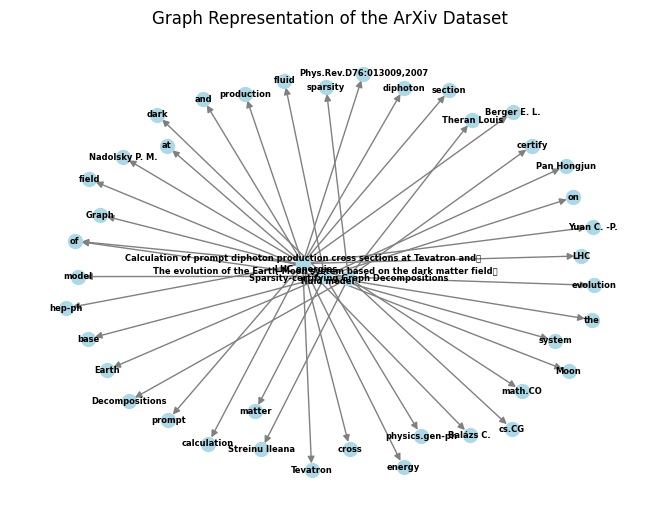

In [42]:
edge_index_data = data['paper', 'written_by', 'author'].edge_index

# # Entferne alle nicht-alphanumerischen Zeichen aus Titeln und Autorennamen
# cleaned_titles = [re.sub(r'\W+', '', title) for title in list_of_titles]
# cleaned_authors = [re.sub(r'\W+', '', author) for author in list_of_authors]

# Erstelle einen leeren gerichteten Graphen
G = nx.DiGraph()

# Füge Knoten (Autoren) und Kanten (Verbindungen) zum Graphen hinzu
for paper_id, author_id in zip(list_of_titles, list_of_authors):
    G.add_node(author_id)
    G.add_edge(paper_id, author_id, weight=0.2)

for paper_id, category in zip(list_of_paper_cat, list_of_categories):
    G.add_node(category)
    G.add_edge(paper_id, category, weight=1)

for paper_id, journal in zip(list_of_paper_journal, list_of_journals):
    G.add_node(journal)
    G.add_edge(paper_id, journal)

# for paper_id, word in zip(list_of_paper_word, list_of_words):
#     G.add_node(word)
#     G.add_edge(paper_id, word)

for paper_id, word_in_title in zip(list_of_paper_titleword, list_of_titlewords):
    G.add_node(word_in_title)
    G.add_edge(paper_id, word_in_title)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

pos = nx.spring_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph Representation of the ArXiv Dataset")
plt.show()


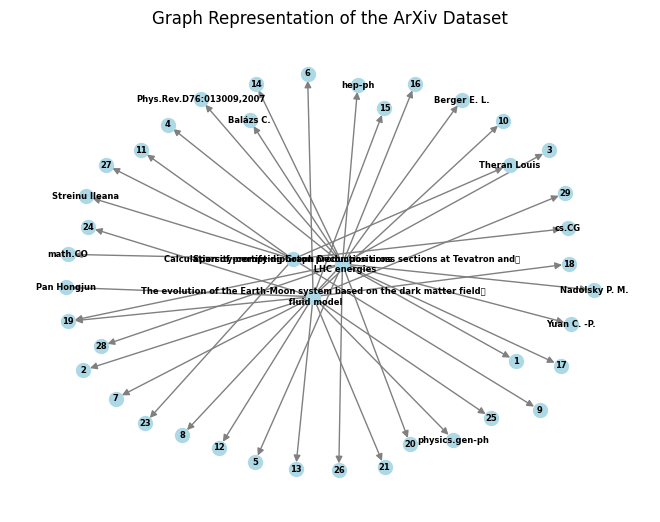

In [43]:
# Erstelle einen leeren gerichteten Graphen
G = nx.DiGraph()

# Füge Knoten (Autoren) und Kanten (Verbindungen) zum Graphen hinzu
for paper_id, author_id in zip(list_of_titles, list_of_authors):
    G.add_node(author_id)
    G.add_edge(paper_id, author_id)

for paper_id, category in zip(list_of_paper_cat, list_of_categories):
    G.add_node(category)
    G.add_edge(paper_id, category)

for paper_id, journal in zip(list_of_paper_journal, list_of_journals):
    G.add_node(journal)
    G.add_edge(paper_id, journal)

# for paper_id, word in zip(list_of_paper_word, list_of_words):
#     G.add_node(word)
#     G.add_edge(paper_id, word)

# Verwende die gemappten Zahlen für die Wörter
for paper_id, word_index in zip(list_of_paper_titleword, edge_index_list_has_titleword[1]):
    G.add_node(word_index)
    G.add_edge(paper_id, word_index)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

pos = nx.spring_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph Representation of the ArXiv Dataset")
plt.show()

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from collections import Counter
from math import log
import torch
import networkx as nx
import matplotlib.pyplot as plt

In [45]:
list_of_titles

['Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
 'Calculation of prompt diphoton production cross sections at Tevatron and\r\n  LHC energies',
 'Sparsity-certifying Graph Decompositions',
 'Sparsity-certifying Graph Decompositions',
 'The evolution of the Earth-Moon system based on the dark matter field\r\n  fluid model']

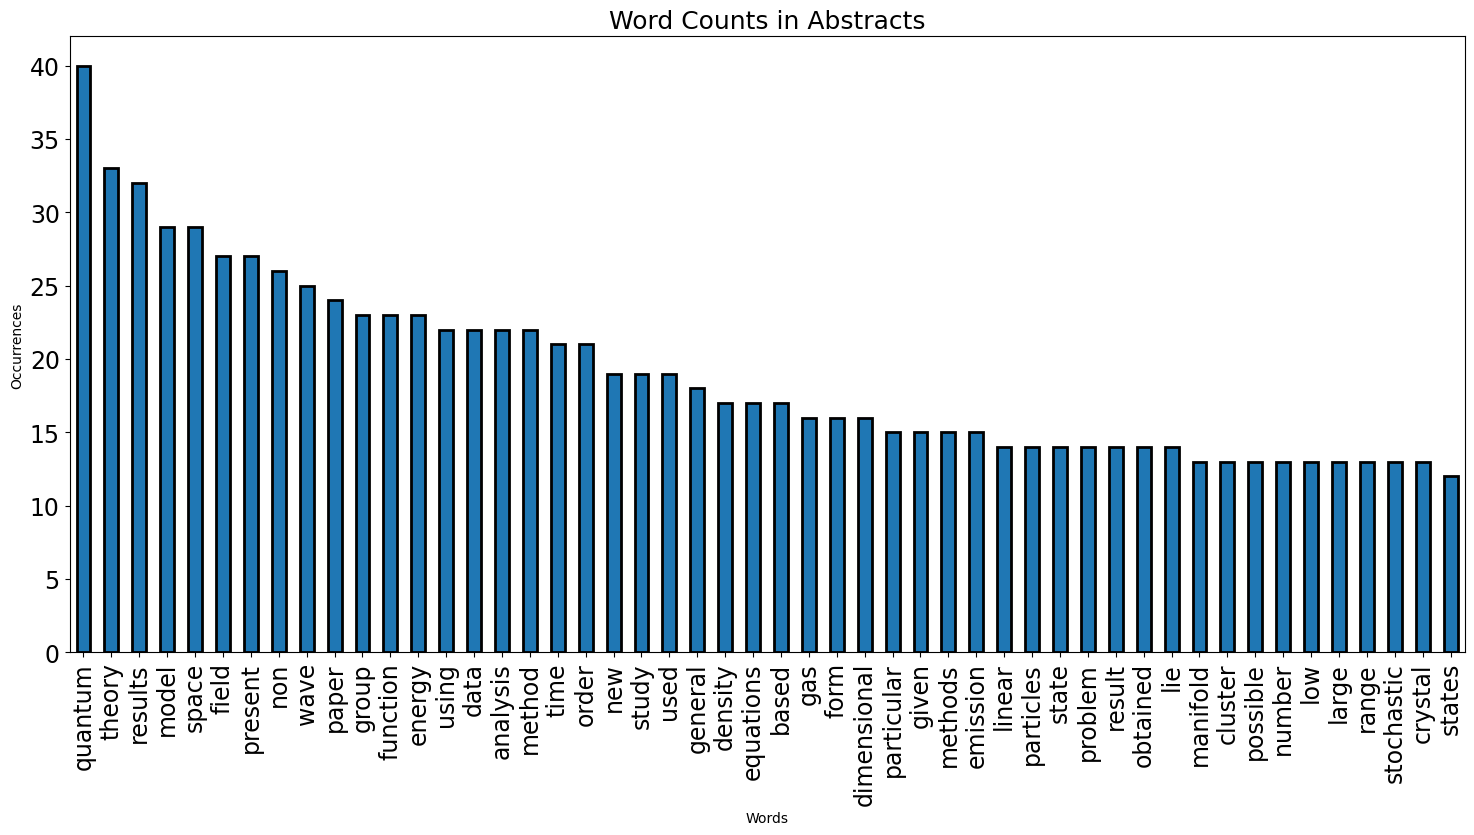

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

# Ihr DataFrame und die Spalte 'abstract'
abstracts = df[:100]['abstract'].tolist()

counter = CountVectorizer(stop_words='english')
count_matrix = counter.fit_transform(abstracts)

# Verwenden Sie die entsprechende Methode je nach Ihrer scikit-learn Version
try:
    features = counter.get_feature_names_out()
except AttributeError:
    features = counter.get_feature_names()

abstracts_counter = pd.Series(count_matrix.toarray().sum(axis=0), 
                              index=features).sort_values(ascending=False)

bar_graph = abstracts_counter[:50].plot(kind='bar', figsize=(18,8), alpha=1, fontsize=17, rot=90, edgecolor='black', linewidth=2,
            title='Word Counts in Abstracts')
bar_graph.set_xlabel('Words')
bar_graph.set_ylabel('Occurrences')
bar_graph.title.set_size(18)
plt.show()


In [47]:
# Calculate TF-IDF Values for !title!

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(list_of_titles)

# TF-IDF-Werte für jedes Wort in jedem Dokument
tfidf_values = X.toarray()
tfidf_values

array([[0.29151512, 0.29151512, 0.        , 0.29151512, 0.        ,
        0.29151512, 0.        , 0.        , 0.29151512, 0.        ,
        0.29151512, 0.        , 0.        , 0.        , 0.        ,
        0.29151512, 0.        , 0.        , 0.        , 0.2553591 ,
        0.        , 0.29151512, 0.29151512, 0.29151512, 0.        ,
        0.        , 0.29151512, 0.        ],
       [0.29151512, 0.29151512, 0.        , 0.29151512, 0.        ,
        0.29151512, 0.        , 0.        , 0.29151512, 0.        ,
        0.29151512, 0.        , 0.        , 0.        , 0.        ,
        0.29151512, 0.        , 0.        , 0.        , 0.2553591 ,
        0.        , 0.29151512, 0.29151512, 0.29151512, 0.        ,
        0.        , 0.29151512, 0.        ],
       [0.29151512, 0.29151512, 0.        , 0.29151512, 0.        ,
        0.29151512, 0.        , 0.        , 0.29151512, 0.        ,
        0.29151512, 0.        , 0.        , 0.        , 0.        ,
        0.29151512, 0.    

In [48]:
# # Calculate PMI Values

# # Beispielwerte
# word_count_a = 10
# word_count_b = 15
# count_both = 5
# total_documents = 100

# def calculate_pmi(word_count_a, word_count_b, count_both, total_documents):
#     p_a = word_count_a / total_documents
#     p_b = word_count_b / total_documents
#     p_ab = count_both / total_documents
#     return log(p_ab / (p_a * p_b), 2)

# pmi_value = calculate_pmi(word_count_a, word_count_b, count_both, total_documents)

In [49]:
# Assign the weights

# von HeteroObjekt
data['paper', 'has_word', 'word'].edge_attr = torch.tensor(tfidf_values, dtype=torch.float)
# data['word', 'cooccurs_with', 'word'].edge_attr = torch.tensor([[pmi_value]], dtype=torch.float)

doc_id: 0, word_id: energies, weight: 0.3333333333333333
doc_id: 0, word_id: lhc, weight: 0.3333333333333333
doc_id: 0, word_id: tevatron, weight: 0.3333333333333333
doc_id: 0, word_id: sections, weight: 0.3333333333333333
doc_id: 0, word_id: cross, weight: 0.3333333333333333
doc_id: 0, word_id: production, weight: 0.3333333333333333
doc_id: 0, word_id: diphoton, weight: 0.3333333333333333
doc_id: 0, word_id: prompt, weight: 0.3333333333333333
doc_id: 0, word_id: calculation, weight: 0.3333333333333333


C:\Users\Ilgar\AppData\Local\Temp\ipykernel_24348\1328852984.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  pmi = math.log((count_word1_word2 * total_count) / (count_word1 * count_word2), 2)


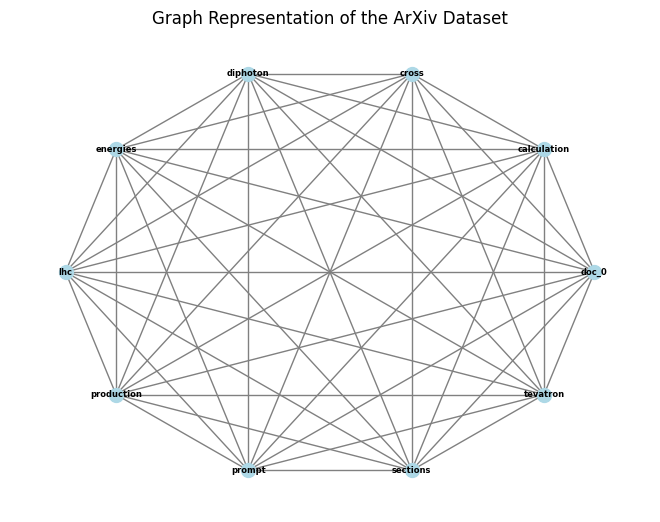

In [50]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import math
import itertools

# Angenommen, df ist Ihr DataFrame mit einer Spalte 'document' für Dokumente
documents = df['title'][:1].tolist()

# Berechnung der TF-IDF-Werte
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Erstellung des Graphen
G = nx.Graph()

# Hinzufügen von Dokument- und Wortknoten
for doc_id, doc in enumerate(documents):
    G.add_node(f'doc_{doc_id}', type='document')

for word in feature_names:
    G.add_node(word, type='word')

# Hinzufügen von Dokument-Wort-Kanten mit TF-IDF-Gewichtungen
for doc_id in range(tfidf_matrix.shape[0]):
    for word_id in tfidf_matrix[doc_id].nonzero()[1]:
        tfidf_weight = tfidf_matrix[doc_id, word_id]
        G.add_edge(f'doc_{doc_id}', feature_names[word_id], weight=tfidf_weight)
        print(f"doc_id: {doc_id}, word_id: {feature_names[word_id]}, weight: {tfidf_weight}")
        
# Berechnung der PMI-Werte für Wort-Wort-Kanten
word_counts = Counter(np.array(tfidf_matrix.sum(axis=0)).flatten())
total_count = sum(word_counts.values())
word_pairs = itertools.combinations(feature_names, 2)

for word1, word2 in word_pairs:
    count_word1 = word_counts[word1]
    count_word2 = word_counts[word2]
    count_word1_word2 = (tfidf_matrix[:, feature_names.tolist().index(word1)] 
                         + tfidf_matrix[:, feature_names.tolist().index(word2)]).sum()
    pmi = math.log((count_word1_word2 * total_count) / (count_word1 * count_word2), 2)
    if pmi > 0:
        G.add_edge(word1, word2, weight=pmi)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

# circular_layout sonst Zahl zu groß für Visualisierung von pmi, davor spring genommen
pos = nx.circular_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')

# # Gewichte der Kanten holen
# edge_weights = nx.get_edge_attributes(G, 'weight')
# # Kanten-Labels zeichnen
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=5)

plt.title("Graph Representation of the ArXiv Dataset")
plt.show()

In [51]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# corpus = df["title"][:4]
# vectorizer = TfidfVectorizer()

# # TD-IDF Matrix
# X = vectorizer.fit_transform(corpus)

# # extracting feature names
# tfidf_tokens = vectorizer.get_feature_names_out()

In [52]:
# import pandas as pd

# result = pd.DataFrame(
#     data=X.toarray(), 
#     index=["Doc1", "Doc2", "Doc3", "Doc4"], 
#     columns=tfidf_tokens
# )

# result

) missing from current font.s\NLP\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


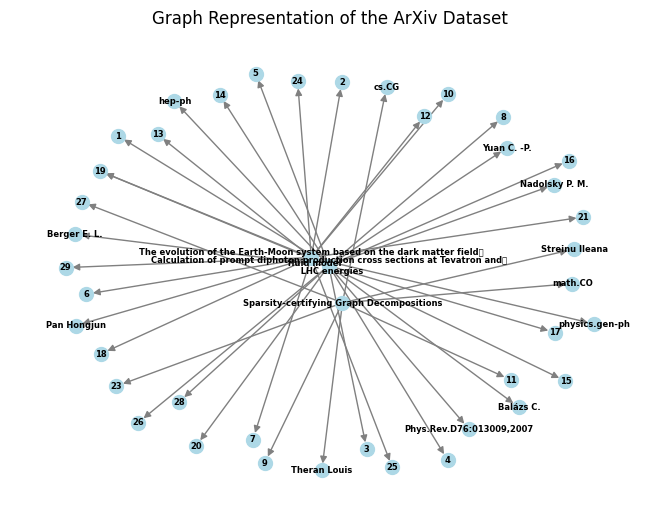

In [53]:
# Erstelle einen leeren gerichteten Graphen
G = nx.DiGraph()

# Füge Knoten (Autoren) und Kanten (Verbindungen) zum Graphen hinzu
for paper_id, author_id in zip(list_of_titles, list_of_authors):
    G.add_node(author_id)
    G.add_edge(paper_id, author_id)

for paper_id, category in zip(list_of_paper_cat, list_of_categories):
    G.add_node(category)
    G.add_edge(paper_id, category)

for paper_id, journal in zip(list_of_paper_journal, list_of_journals):
    G.add_node(journal)
    G.add_edge(paper_id, journal)

# for paper_id, word in zip(list_of_paper_word, list_of_words):
#     G.add_node(word)
#     G.add_edge(paper_id, word)

# Verwende die gemappten Zahlen für die Wörter
for paper_id, word_index in zip(list_of_paper_titleword, edge_index_list_has_titleword[1]):
    G.add_node(word_index)
    G.add_edge(paper_id, word_index)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

pos = nx.spring_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph Representation of the ArXiv Dataset")
plt.show()

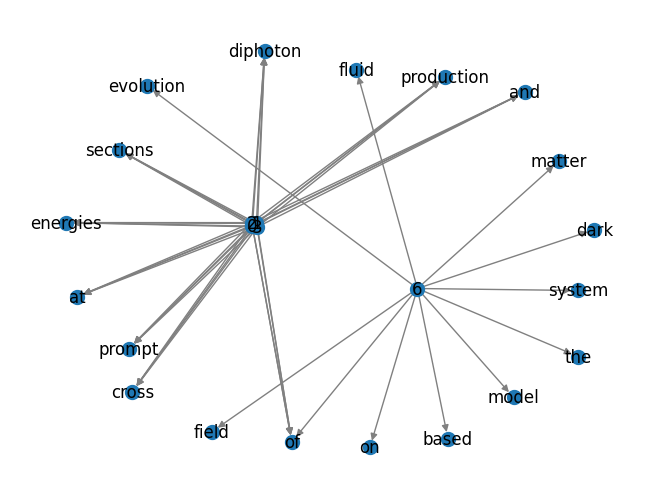

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt

# Angenommen, list_of_titles enthält die Titel aller Papers
corpus = list_of_titles  # oder eine andere Sammlung von Texten

# Berechnen der TF-IDF Werte
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

# Erstellen eines Graphen
G = nx.DiGraph()

# Füge Knoten und Kanten mit TF-IDF Gewichten hinzu
for paper_id, title in enumerate(corpus):
    words = title.split()  # Annahme: Titel sind durch Leerzeichen getrennte Wörter
    for word in words:
        if word in feature_names:
            word_index = feature_names.tolist().index(word)
            tfidf_weight = tfidf_matrix[paper_id, word_index]
            G.add_node(word)
            G.add_edge(paper_id, word, weight=tfidf_weight)

# Hier können Sie weitere Knoten und Kanten hinzufügen, wie oben in Ihrer Beschreibung

# from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'df' is your DataFrame and it has a column 'abstract' for paper abstracts
# abstracts = df['abstract'][:3].tolist()

# # Compute TF-IDF scores
# vectorizer = TfidfVectorizer()
# tfidf_matrix = vectorizer.fit_transform(abstracts)
# feature_names = vectorizer.get_feature_names_out()

# Your existing code for graph creation
# ...
# G = nx.DiGraph() or any similar line you have

# Add nodes and edges with TF-IDF weights to the graph
# for paper_id, abstract in enumerate(abstracts):
#     # Extract words/terms from the abstract
#     words = abstract.split()  # or use a more sophisticated tokenizer
#     for word in words:
#         if word in feature_names:
#             word_index = feature_names.tolist().index(word)
#             tfidf_weight = tfidf_matrix[paper_id, word_index]
#             G.add_node(word)
#             G.add_edge(paper_id, word, weight=tfidf_weight)

# Your existing code to manipulate or visualize the graph
# ...


# Zeichnen des Graphen
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=100, edge_color='gray')
plt.show()


In [55]:
edge_index_data = data['paper', 'written_by', 'author'].edge_index

# # Entferne alle nicht-alphanumerischen Zeichen aus Titeln und Autorennamen
# cleaned_titles = [re.sub(r'\W+', '', title) for title in list_of_titles]
# cleaned_authors = [re.sub(r'\W+', '', author) for author in list_of_authors]

# Erstelle einen leeren gerichteten Graphen
G = nx.DiGraph()

# Füge Knoten (Autoren) und Kanten (Verbindungen) zum Graphen hinzu
for paper_id, author_id in zip(list_of_titles, list_of_authors):
    G.add_node(author_id)
    G.add_edge(paper_id, author_id, weight=tfidf)

for paper_id, category in zip(list_of_paper_cat, list_of_categories):
    G.add_node(category)
    G.add_edge(paper_id, category, weight=5)

for paper_id, journal in zip(list_of_paper_journal, list_of_journals):
    G.add_node(journal)
    G.add_edge(paper_id, journal)

# for paper_id, word in zip(list_of_paper_word, list_of_words):
#     G.add_node(word)
#     G.add_edge(paper_id, word)

for paper_id, word_in_title in zip(list_of_paper_titleword, list_of_titlewords):
    G.add_node(word_in_title)
    G.add_edge(paper_id, word_in_title)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

pos = nx.spring_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph Representation of the ArXiv Dataset")
plt.show()


NameError: name 'tfidf' is not defined

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Erstelle einen leeren gerichteten Graphen
G = nx.DiGraph()

# Füge Knoten und Kanten zum Graphen hinzu
for paper_id, author_id in zip(list_of_titles, list_of_authors):
    G.add_node(paper_id)
    G.add_node(author_id)
    G.add_edge(paper_id, author_id)

for paper_id, category in zip(list_of_paper_cat, list_of_categories):
    G.add_node(paper_id)
    G.add_node(category)
    G.add_edge(paper_id, category)

for paper_id, journal in zip(list_of_paper_journal, list_of_journals):
    G.add_node(paper_id)
    G.add_node(journal)
    G.add_edge(paper_id, journal)

# Verwende die gemappten Zahlen für die Wörter
for paper_id, word_index in zip(list_of_paper_titleword, edge_index_list_has_titleword[1]):
    G.add_node(paper_id)
    G.add_node(word_index)
    G.add_edge(paper_id, word_index)

# Gewichte zuweisen (stellen Sie sicher, dass tfidf ein Skalar ist)
for paper_id, word_in_title, tfidf in zip(list_of_paper_titleword, list_of_titlewords, tfidf_values):
    G.add_node(paper_id)
    G.add_node(word_in_title)
    G.add_edge(paper_id, word_in_title, weight=tfidf)

# Zeige den Graphen an, deaktiviere die Verarbeitung von LaTeX-Symbolen
plt.rcParams['text.usetex'] = False

# Visualisierung des Graphen
pos = nx.spring_layout(G)  # Layout des Graphen
nx.draw(G, pos, with_labels=True, font_size=6, node_size=100, node_color='lightblue', font_color='black', font_weight='bold', edge_color='gray')
plt.title("Graph Representation of the Dataset")
plt.show()


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (48,) + inhomogeneous part.